In [1]:
import events
import settings
import metrics
import plotting

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy import sparse

import networkx as nx
import os
import itertools

In [2]:
log = "..//logs//20220922224810"

log_settings = settings.load(f"{log}//settings.log")
log_metrics = metrics.load(f"{log}//metrics.log")

events.analyze(
    f"{log}//events",
    counter := events.EventCallback(events.EventCounterData),
    updates := events.EventCallback(events.UpdatesData),
    timeline := events.EventCallback(events.TimelineData),
    reachability := events.EventCallback(events.ReachabilityData),
    received := events.EventCallback(events.ReceivedData)
)

In [8]:
timeline[0].i2e

array(['ReceiveEvent', 'UpdateEvent', 'ContactEvent', 'SendCurrentEvent',
       'TimeoutEvent'], dtype='<U20')

In [25]:
interesting = {
    user: len(edges)
    for user, edges in enumerate(reachability.msgs)
    if len(set(dst for _, dst in edges)) < len(edges)}

In [26]:
edges = reachability.msgs[31]
idx = events.index_edges(edges)
edges = set((idx[v1], idx[v2]) for v1, v2 in edges)

graph = nx.DiGraph()
graph.add_edges_from(edges)

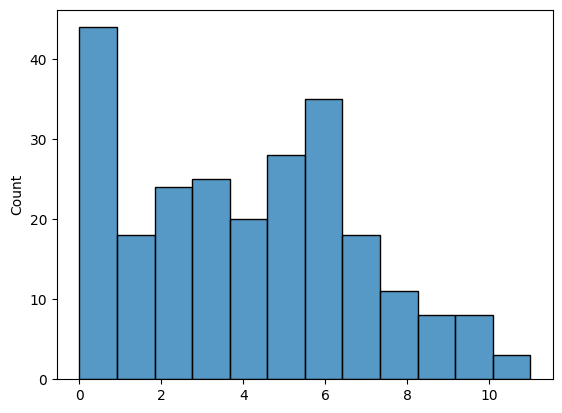

In [3]:
sns.histplot(updates.updates, bins=len(set(updates.updates)));

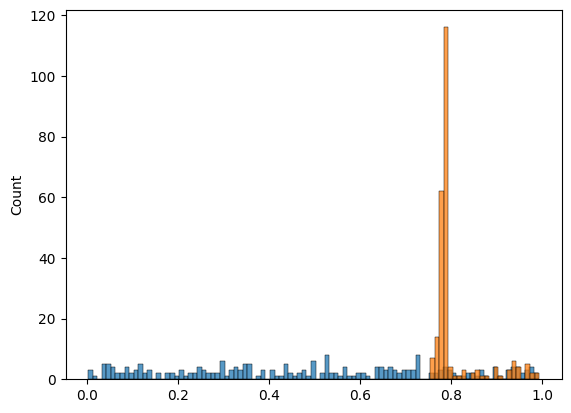

In [4]:
sns.histplot(updates.initials, binwidth=0.01)
sns.histplot(updates.finals, binwidth=0.01);

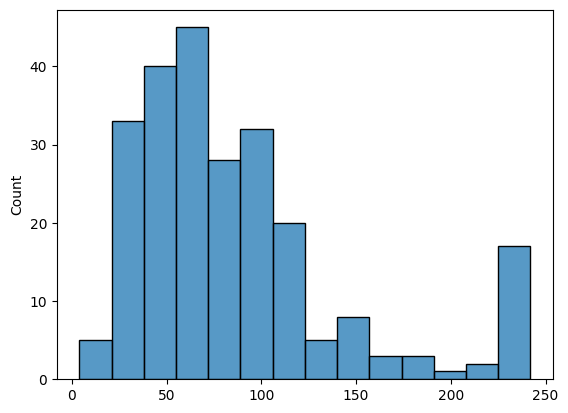

In [5]:
sns.histplot(reachability.source_size());

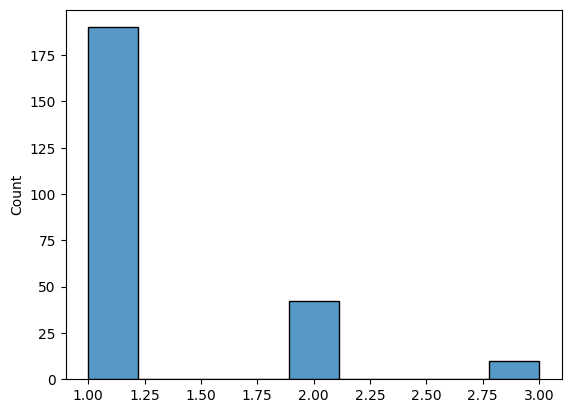

In [24]:
sns.histplot(reachability.msg_reach());

In [21]:
positions, n_events = plotting.event_plot_positions(timeline, x_axis="time")

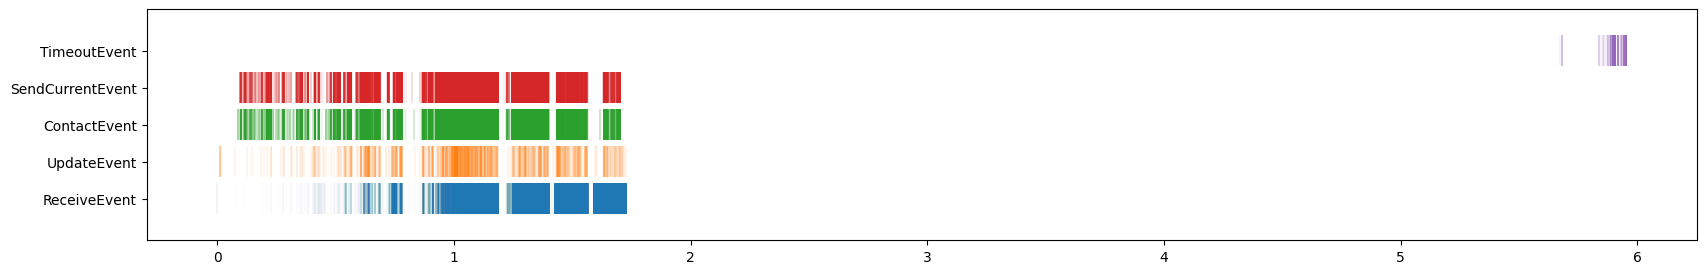

In [29]:
line_len = 5
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(111)
offsets = np.arange(n_events) * (line_len + 1)
ax.axes.set_yticks(offsets)
ax.axes.set_yticklabels(timeline.i2e)
ax.eventplot(
    positions,
    colors=[f"C{i}" for i in range(n_events)],
    linelengths=np.repeat(line_len, n_events),
    lineoffsets=np.arange(n_events) * (line_len + 1), 
    linewidths=[0.01, 0.1, 0.1, 0.1, 0.1]);

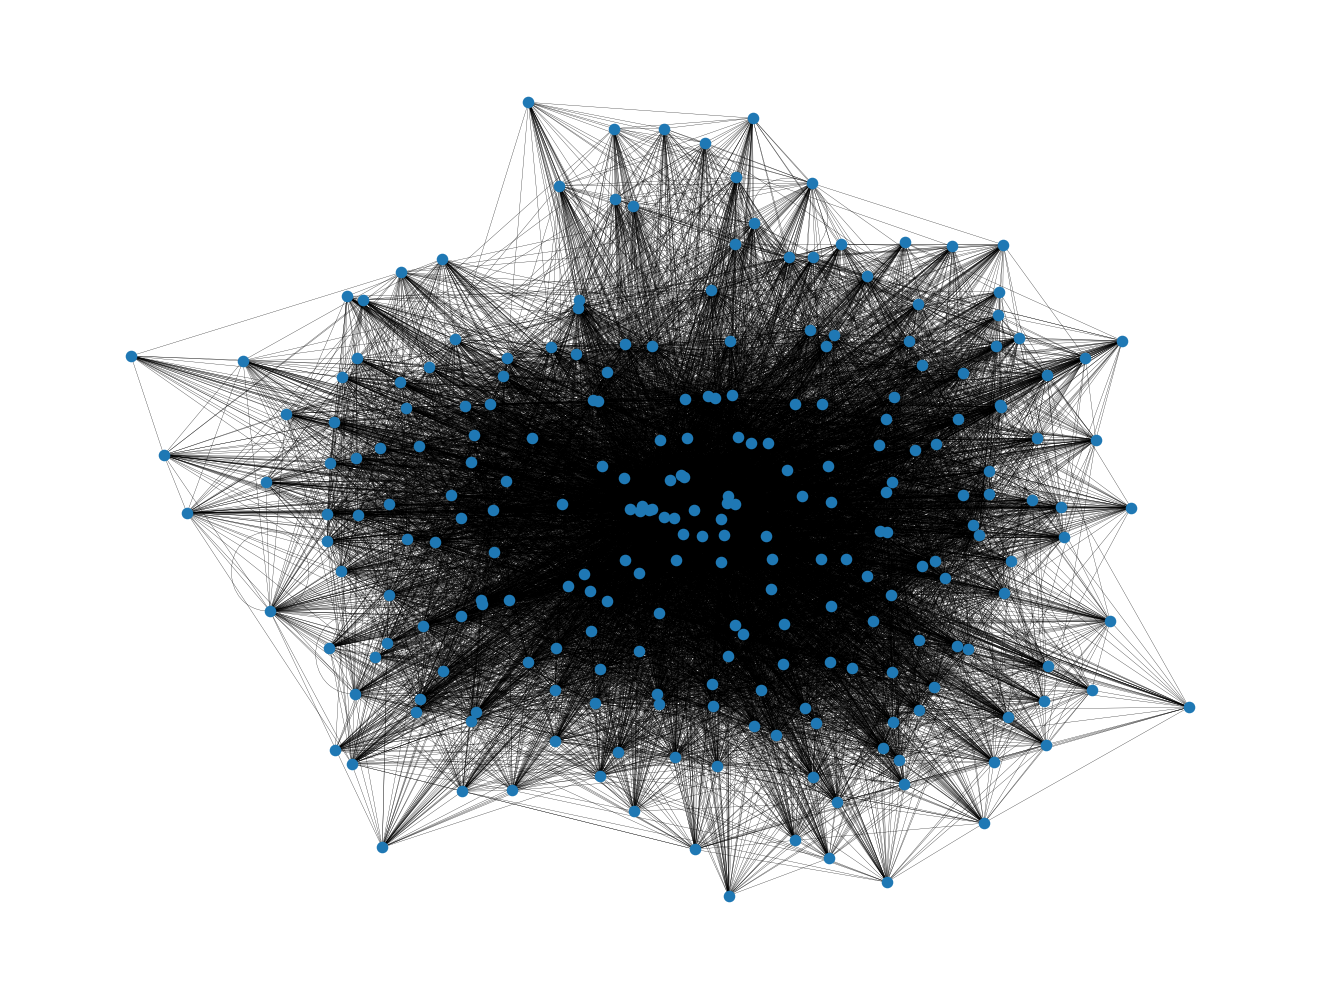

In [28]:
graph = nx.from_scipy_sparse_array(reachability.adj)
plt.figure(dpi=200)
nx.draw(
    graph,
    pos=nx.spring_layout(graph),
    width=0.1,
    with_labels=False,
    node_size=10)